
Si tratta di un compito regressione, in cui l'obiettivo è prevedere l'area bruciata dagli incendi boschivi, nella regione nordorientale del Portogallo, utilizzando dati meteorologici e di altro tipo.
DATASET: Multivariato
AREA TEMATICA: Clima e Ambiente
(Basato su campionu reali)

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import accuracy_score

from mlxtend.plotting import plot_decision_regions

Import del dataset da file csv come dataframe usando pandas

In [25]:
file_path = './dataset/forestfires.csv'

# CSV -> DataFrame
df = pd.read_csv(file_path)

# Mostra le prime righe del DataFrame
print(df.head())

   X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area
0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0
1  7  4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0
2  7  4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0
3  8  6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0
4  8  6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0


La funzione df.describe() è un metodo molto utile di pandas, una libreria Python per l'elaborazione dei dati. Serve per generare statistiche descrittive di base per le colonne numeriche (o categoriali se specificato) di un DataFrame.

In [26]:
df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


Analizzando le statistiche si puo notare come la caratteristica rain ha una media molto piu bassa rispetto il massimo (<< della metà), lo stesso anche per l'output che sembra essere estremamente sbilanciata verso lo zero. una visualizzazione dei dati potrebbe aiutare a capire la distribuzione.

<Axes: xlabel='area', ylabel='Count'>

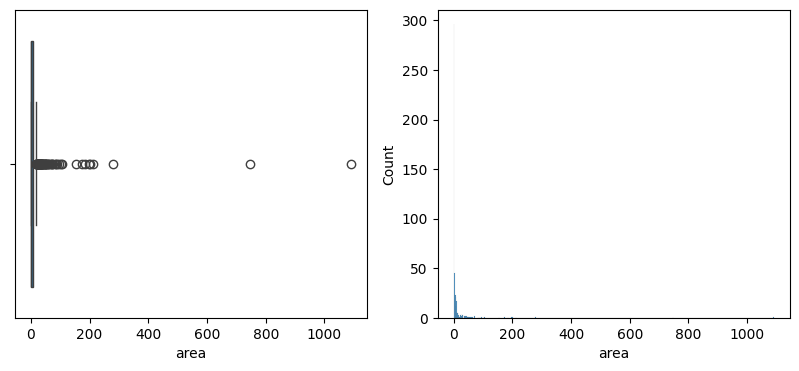

In [27]:

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.boxplot(data = df, x = df['area']) #for outliers
plt.subplot(1, 2, 2)
sns.histplot(data = df, x = df['area'], kde = False)

Un modo per riportare l'area su una scala migliore è l'utilizzo del logaritmo. Questa tecnica, oltre che ridurre questo sbilanciamento dei dati potrebbe avere, come effetto collaterale, la capacità predittiva del modello.

<Axes: xlabel='log_area', ylabel='Count'>

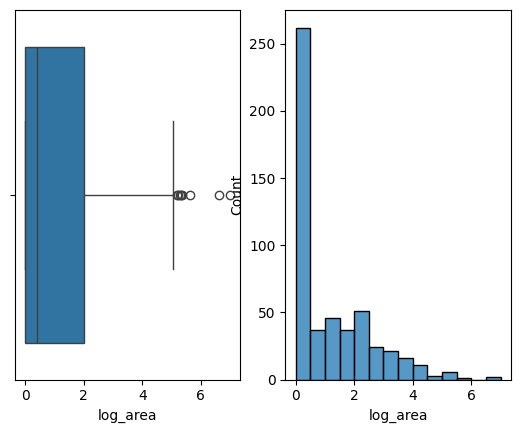

In [28]:
# Trasformazione logaritmica della variabile target
df['log_area'] = np.log(df['area'] + 1)

plt.subplot(1, 2, 1)
sns.boxplot(data = df, x = df['log_area']) #for outliers
plt.subplot(1, 2, 2)
sns.histplot(data = df, x = df['log_area'], kde = False)

Ora diamo un'occhiata anche alla variabile 'rain'

<Axes: xlabel='rain', ylabel='Count'>

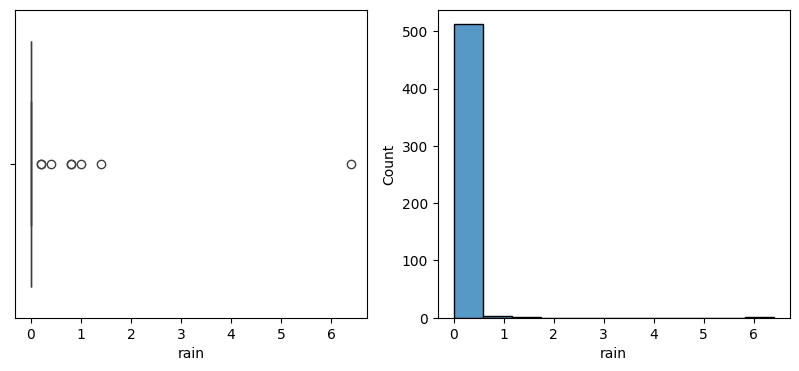

In [29]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.boxplot(data = df, x = df['rain']) #for outliers
plt.subplot(1, 2, 2)
sns.histplot(data = df, x = df['rain'], kde = False)

Anche in questo caso i valori sono molto schiacciati verso lo zero... Si può provare anche qui un cambio di scala utilizzando il logaritmo ma non sarebbe opportuno, perchè i valori della pioggia sono fondamentali nell'apprendimento perchè sono una parte fondamentale nella previsione di incendi e il logaritmo ne riduce l'importanza (coerentemente a quanto detto non è opportuno rimuovore gli outliers) 

Ora riproponiamo dati per fare ulteriori analisi sulle variabili stringa

In [30]:
df.drop(columns=['area'])

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,log_area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.000000
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.000000
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.000000
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.000000
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,2.006871
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,4.012592
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,2.498152
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.000000


Chiarament i mesi e i giorni non sono caratteristiche numerice, quindi vanno codificate. Qui è possibile fare due considerazioni distinte: per i MESI possiamo adottare una codifica ciclica dato che sono essi stessi dei cicli, ma soprattutto generalmente esistono dei mesi piu caldi e piu freddi e questa relazione non è indipendente dai mesi; mentre pwr quanto riguarda i GIORNI si può pensare di utilizzare OneHotEncoding per non aggiungere ulteriori relazioni d'ordine al modello (in qaunto idealmente non necessarie per i giorni).

In [ ]:
enc = preprocessing.OrdinalEncoder(categories=[['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']])

months = df['month'].unique()

# Applica la codifica alla colonna 'month'
df['month_encoded'] = enc.fit_transform(df[['month']])
df['month_encoded'] = df['month_encoded'] + 1

# Applica la codifica ciclica
df['Month_encoded_sin'] = np.sin(2 * np.pi * df['month_encoded'] / len(months))  # Codifica seno

# Stampe generali di verifica
print("months: ", len(months))
df

# DA FINIRE LA CODIFICA DEI GIORNI

months:  12


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log_area,month_encoded,Month_encoded_sin
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00,0.000000,3.0,1.000000
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00,0.000000,10.0,-0.866025
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00,0.000000,10.0,-0.866025
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00,0.000000,3.0,1.000000
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00,0.000000,3.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44,2.006871,8.0,-0.866025
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29,4.012592,8.0,-0.866025
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16,2.498152,8.0,-0.866025
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00,0.000000,8.0,-0.866025
